In [1]:
import re
import json
import pandas as pd
import numpy as np
import contractions
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Amos\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def load_file(file_path):
    """
    :param file_path: path to the json file
    :return: an array in which each entry is tuple [review, classification label]
    """
    with open(file_path) as json_file:
        raw_data = json.load(json_file)
        return convert_data(raw_data)

def convert_data(raw_data):
    data = []
    for elem in raw_data:
        data.append([elem["comment"], elem["label"]])
    return data

In [3]:
import os 

df = pd.DataFrame([], columns = ['text', 'label'])

dir_name = 'json/'
for file in os.listdir(dir_name):
    data = load_file(os.path.join(dir_name, file))
    df = pd.concat([df, pd.DataFrame(data, columns = ['text', 'label'])])
df = df.reset_index().drop(columns=['index'])

df

,text,label
0,"Besides the occasional crash, this is an amazi...",Bug
1,This could be a great app if it was predictabl...,Bug
2,I can't open since the last 2 updates Pop-ups ...,Bug
3,Use to love this app but it's not working afte...,Bug
4,"Urrrrm\tAfter my third re installing, it final...",Bug
...,...,...
2831,Crashes on lenovo tablet\tAfter a while this a...,Not_UserExperience
2832,Terrible\tIt took forever to download\r,Not_UserExperience
2833,Norefund wtf\tSeems like a nice game but not w...,Not_UserExperience
2834,Need for speed most wanted\tWould be a good ga...,Not_UserExperience


In [4]:
# drop duplicates
df['freq'] = df.groupby(list(df.columns[:-1])).transform('count')
mask = [] 

for i, row in df.iterrows():
    discard = False
    if row['freq'] > 1:
        duplicates = df[df['text'] == row['text']]
        all_labels = duplicates['label'].unique()
        positive_count = sum([not x.startswith('Not') for x in all_labels])
        discard = positive_count > 1

    mask.append(discard)


df = df[~np.array(mask)] 
df = df.drop(columns=['freq'])
df

,text,label
0,"Besides the occasional crash, this is an amazi...",Bug
1,This could be a great app if it was predictabl...,Bug
2,I can't open since the last 2 updates Pop-ups ...,Bug
3,Use to love this app but it's not working afte...,Bug
5,This app serves its purpose for me perfectly e...,Bug
...,...,...
2831,Crashes on lenovo tablet\tAfter a while this a...,Not_UserExperience
2832,Terrible\tIt took forever to download\r,Not_UserExperience
2833,Norefund wtf\tSeems like a nice game but not w...,Not_UserExperience
2834,Need for speed most wanted\tWould be a good ga...,Not_UserExperience


In [5]:
# drop negative
mask = df['label'].str.startswith('Not')
df = df[~mask]

df

,text,label
0,"Besides the occasional crash, this is an amazi...",Bug
1,This could be a great app if it was predictabl...,Bug
2,I can't open since the last 2 updates Pop-ups ...,Bug
3,Use to love this app but it's not working afte...,Bug
5,This app serves its purpose for me perfectly e...,Bug
...,...,...
2461,Very nice radar app. Easy to use,UserExperience
2462,"Works great! Maps are good, better than my Gar...",UserExperience
2463,I love this app it is really handy when u r ou...,UserExperience
2464,The new release shows what a mature iOS app sh...,UserExperience


<AxesSubplot: xlabel='label'>

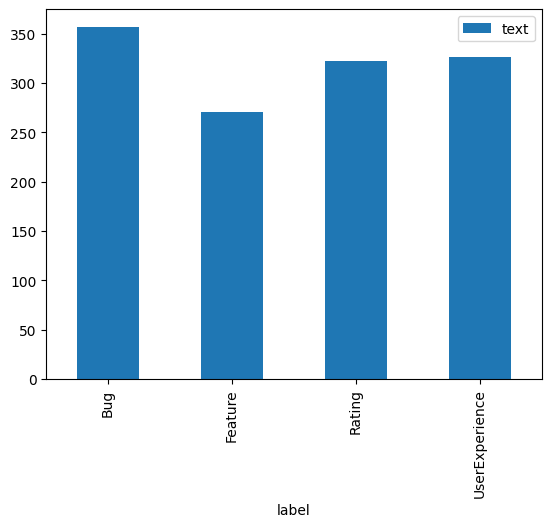

In [6]:
df.groupby('label').nunique().plot(kind='bar')

In [10]:
df = df.copy()

In [13]:
# contraction
import contractions

df['text_cleaned'] = df['text']
for index, row in df.iterrows():
    df['text_cleaned'][index] = contractions.fix(row['text'])

In [16]:
df.loc[3]['text_cleaned']

'Use to love this app but it is not working after new update. Pages will not scroll up or down...none of the different tabs work...it is frozen! Please fix AS SOON AS POSSIBLE!!!'

In [17]:
# Text cleaning
df['text_cleaned'] = df['text_cleaned'].str.replace(r"[^a-zA-Z]", " ", regex=True)
df['text_cleaned'] = df['text_cleaned'].str.lower()

In [19]:
df['text'].loc[3]

"Use to love this app but it's not working after new update. Pages won't scroll up or down...none of the different tabs work...it's frozen! Please fix ASAP!!!"

In [18]:
df['text_cleaned'].loc[3]

'use to love this app but it is not working after new update  pages will not scroll up or down   none of the different tabs work   it is frozen  please fix as soon as possible   '

In [20]:
# lemmatization
from nltk.stem import WordNetLemmatizer
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

lemmatized = []
for i, row in df.iterrows():
    tokens = row['text_cleaned'].split()
    lemmatized_list = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in tokens]
    lemmatized.append(" ".join(lemmatized_list))

df['lemmatized'] = lemmatized

In [21]:
df['lemmatized'].loc[3]

'use to love this app but it be not work after new update page will not scroll up or down none of the different tabs work it be freeze please fix as soon as possible'

In [25]:
# stop word

stop_words = list(stopwords.words('english'))
for stop_word in stop_words:
    pattern = r"\b" + stop_word + r"\b"
    df['lemmatized'] = df['lemmatized'].str.replace(pattern, '', regex=True)

df['lemmatized'] = df['lemmatized'].str.replace(r'\s+', ' ', regex=True)

In [26]:
df['lemmatized'].loc[3]

'use love app work new update page scroll none different tabs work freeze please fix soon possible'

In [30]:
df = df[['lemmatized', 'label']]
df = df.rename(columns={'lemmatized': 'text'})
df.head()

,text,label
0,besides occasional crash amaze product tons po...,Bug
1,could great app predictable full bug unpredic...,Bug
2,cannot open since last update pop go crazy ip...,Bug
3,use love app work new update page scroll none ...,Bug
5,app serve purpose perfectly except mobile dep...,Bug


In [38]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(df['label'])
df['label'] = le.transform(df['label'])

In [39]:
df

,text,label
0,besides occasional crash amaze product tons po...,0
1,could great app predictable full bug unpredic...,0
2,cannot open since last update pop go crazy ip...,0
3,use love app work new update page scroll none ...,0
5,app serve purpose perfectly except mobile dep...,0
...,...,...
2461,nice radar app easy use,3
2462,work great map good better garmin default lowe...,3
2463,love app really handy r woods,3
2464,new release show mature ios app look like per...,3


In [41]:
# train - test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.15, random_state=42)

In [42]:
# Text representation
from sklearn.feature_extraction.text import TfidfVectorizer
# Parameter election
ngram_range = (1,2)
min_df = 0.01 # ignore terms that appear in less than 1% of the documents
max_df = 0.8 # ignore terms that appear in more than 80% of the documents
max_features = 300

tfidf = TfidfVectorizer(encoding='utf-8',ngram_range=ngram_range,
                        stop_words=None,lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1092, 280)
(193, 280)


In [46]:
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

rfc = RandomForestClassifier(random_state=42)
rfc.fit(features_train, labels_train)

print('Parameters currently in use:\n')
pprint(rfc.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [56]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [57]:
# First create the base model to tune
base = RandomForestClassifier(random_state=42)
# Definition of the random search
random_search = RandomizedSearchCV(estimator=base, param_distributions=random_grid, n_iter=50, scoring='accuracy',cv=3,verbose=1,random_state=42)

# Fit the random search model
random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


d:\Programs\Anaconda\envs\668\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
d:\Programs\Anaconda\envs\668\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
d:\Programs\Anaconda\envs\668\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the def

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='accuracy', verbose=1)

In [58]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.6043956043956044


In [59]:
best_rfc = random_search.best_estimator_
# fit the model
best_rfc.fit(features_train, labels_train)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=400,
                       random_state=42)

In [60]:
print("Training accuracy: ")
print("Tuned model: ", accuracy_score(labels_train, best_rfc.predict(features_train)))
print("Default model: ", accuracy_score(labels_train, rfc.predict(features_train)))
print("\n\nTest accuracy: ")
print("Tuned model: ", accuracy_score(labels_test, best_rfc.predict(features_test)))
print("Default model: ", accuracy_score(labels_test, rfc.predict(features_test)))

Training accuracy: 
Tuned model:  0.9267399267399268
Default model:  0.98992673992674


Test accuracy: 
Tuned model:  0.5595854922279793
Default model:  0.5595854922279793


In [61]:
pred = best_rfc.predict(features_test)

# Classification report
print("Classification report")
print(classification_report(labels_test,pred))

Classification report
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        61
           1       0.54      0.37      0.43        41
           2       0.45      0.60      0.51        43
           3       0.60      0.50      0.55        48

    accuracy                           0.56       193
   macro avg       0.56      0.54      0.54       193
weighted avg       0.57      0.56      0.56       193



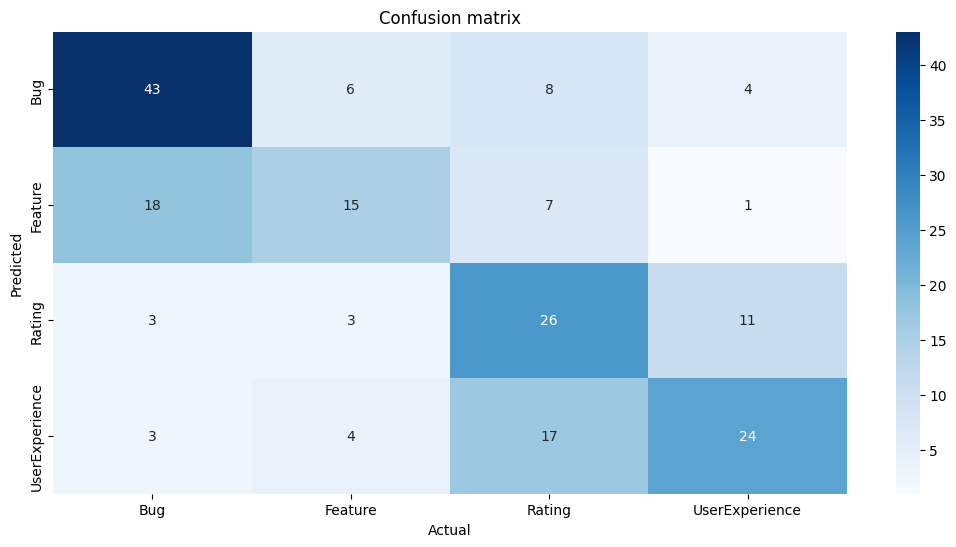

In [62]:
import seaborn as sns
# Confusion matrix
conf_matrix = confusion_matrix(labels_test, pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, annot=True, xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

In [65]:
print("Default Model")
print("Accuracy: " + str(accuracy_score(labels_test, rfc.predict(features_test))))
print("F1 score: "+ str(f1_score(labels_test, rfc.predict(features_test), average=None)))
 
print("\nRandom Model")
print("Accuracy: " + str(accuracy_score(labels_test, best_rfc.predict(features_test))))
print("F1 score: "+ str(f1_score(labels_test, best_rfc.predict(features_test), average=None)))

Default Model
Accuracy: 0.5595854922279793
F1 score: [0.63076923 0.45070423 0.55319149 0.54945055]

Random Model
Accuracy: 0.5595854922279793
F1 score: [0.671875   0.43478261 0.51485149 0.54545455]


In [76]:
(features_train == 0).sum() / (1092* 280)

0.971585557299843